# Import Necessary Library functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
from tensorflow.keras.models import load_model 
import json
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation, Add,DepthwiseConv2D, BatchNormalization, Concatenate, Conv2D, Dense,Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Lambda, LeakyReLU, MaxPooling2D, Multiply, Permute, Reshape, UpSampling2D, AveragePooling2D
import collections
from tensorflow.keras import regularizers
from  tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from pathlib import Path

In [3]:
# Focal Loss function definition
def focal_loss(gamma=2.0, alpha=0.25):
     # Focal Loss function to address class imbalance by focusing on hard-to-classify examples.
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon()) # Clip predictions to avoid log(0) errors
        cross_entropy_loss = -y_true * tf.math.log(y_pred)
        modulating_factor = tf.pow(1.0 - y_pred, gamma)  # Apply modulating factor to down-weight easy examples.
        focal_loss = alpha * modulating_factor * cross_entropy_loss # Calculate final focal loss.
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))
    return focal_loss_fixed

In [4]:
# Functions for evaluation (from organizers)
def save_predictions_to_excel(image_paths, y_pred, output_path):
    """
    Saves predictions along with their probabilities and image paths to an Excel file.

    Parameters:
    - image_paths: List of image file paths.
    - y_pred: Array of predicted class probabilities (shape: [n_samples, n_classes]).
    - output_path: File path for saving the Excel file.
    """
    
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_pred_classes = np.argmax(y_pred, axis=1)
    predicted_class_names = [class_columns[i] for i in y_pred_classes]
    
    df_prob = pd.DataFrame(y_pred, columns=class_columns)
    df_prob.insert(0, 'image_path', image_paths)
    df_class = pd.DataFrame({'image_path': image_paths, 'predicted_class': predicted_class_names})
    
    df_merged = pd.merge(df_prob, df_class, on='image_path')
    df_merged.to_excel(output_path, index=False)

def calculate_specificity(y_true, y_pred):
     """
    Calculates specificity: TN / (TN + FP).
    
    Parameters:
    - y_true: Ground truth binary labels (0 or 1).
    - y_pred: Predicted binary labels (0 or 1).
    
    Returns:
    - specificity: Specificity score, or 0 if denominator is zero.
    """
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

In [5]:
# Functions to save metrics (from organizers)
def generate_metrics_report(y_true, y_pred):
    """
    Generates a comprehensive metrics report for a multi-class classification problem.
    
    Parameters:
    - y_true: Ground truth labels, one-hot encoded (numpy array of shape (n_samples, n_classes)).
    - y_pred: Predicted probabilities for each class (numpy array of shape (n_samples, n_classes)).
    
    Returns:
    - metrics_report: A JSON string containing various performance metrics including AUC-ROC, 
                      specificity, average precision, sensitivity, F1-score, and balanced accuracy.
    """
    class_columns = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    metrics_report = {}

    y_true_classes = np.argmax(y_true, axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    class_report = classification_report(y_true_classes, y_pred_classes, target_names=class_columns, output_dict=True, zero_division=0)

    auc_roc_scores = {class_name: roc_auc_score(y_true[:, i], y_pred[:, i]) for i, class_name in enumerate(class_columns)}
    mean_auc_roc = np.mean(list(auc_roc_scores.values()))
    auc_roc_scores['mean_auc'] = mean_auc_roc

    specificity_scores = {class_name: calculate_specificity(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int)) for i, class_name in enumerate(class_columns)}
    mean_specificity = np.mean(list(specificity_scores.values()))
    specificity_scores['mean_specificity'] = mean_specificity

    average_precision_scores = {}
    for i, class_name in enumerate(class_columns):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        average_precision_scores[class_name] = auc(recall, precision) if len(precision) > 0 else 0.0
    mean_average_precision = np.mean(list(average_precision_scores.values()))
    average_precision_scores['mean_average_precision'] = mean_average_precision

    sensitivity_scores = {class_name: recall_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0) for i, class_name in enumerate(class_columns)}
    mean_sensitivity = np.mean(list(sensitivity_scores.values()))
    sensitivity_scores['mean_sensitivity'] = mean_sensitivity

    f1_scores = {class_name: f1_score(y_true[:, i], (y_pred[:, i] >= 0.5).astype(int), zero_division=0) for i, class_name in enumerate(class_columns)}
    mean_f1_score = np.mean(list(f1_scores.values()))
    f1_scores['mean_f1_score'] = mean_f1_score

    balanced_accuracy = balanced_accuracy_score(y_true_classes, y_pred_classes)

    metrics_report.update(class_report)
    metrics_report['auc_roc_scores'] = auc_roc_scores
    metrics_report['specificity_scores'] = specificity_scores
    metrics_report['average_precision_scores'] = average_precision_scores
    metrics_report['sensitivity_scores'] = sensitivity_scores
    metrics_report['f1_scores'] = f1_scores
    metrics_report['mean_auc'] = mean_auc_roc
    metrics_report['mean_specificity'] = mean_specificity
    metrics_report['mean_average_precision'] = mean_average_precision
    metrics_report['mean_sensitivity'] = mean_sensitivity
    metrics_report['mean_f1_score'] = mean_f1_score
    metrics_report['balanced_accuracy'] = balanced_accuracy

    return json.dumps(metrics_report, indent=4)

In [6]:
train_path = '/kaggle/input/capsule-vision/archive/Dataset/training'
test_path = '/kaggle/input/capsule-vision-test/Testing set'
val_path = '/kaggle/input/capsule-vision/archive/Dataset/validation'
batch_size = 128 #change accordingly
img_height = 224
img_width = 224
no_of_classes = 10
input_shape = (img_height , img_width , 3)


random_seed = np.random.seed(1142)

# Data generator
datagen = ImageDataGenerator(
    rescale=1. / 255,
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    horizontal_flip=False,
    vertical_flip=False
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True,
    class_mode='categorical')

validation_generator = datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')


print(train_generator.class_indices)

Found 37607 images belonging to 10 classes.
Found 16132 images belonging to 10 classes.
Found 4385 images belonging to 1 classes.
{'Angioectasia': 0, 'Bleeding': 1, 'Erosion': 2, 'Erythema': 3, 'Foreign Body': 4, 'Lymphangiectasia': 5, 'Normal': 6, 'Polyp': 7, 'Ulcer': 8, 'Worms': 9}


# Defining the Model and Training

In [7]:
def res_block(x,f):
    """
    Residual block that applies a spatial attention mechanism using average pooling and a 1x1 convolution.
    
    Parameters:
    - x: Input tensor.
    - f: Number of filters for the convolution.
    
    Returns:
    - x4: Output tensor after applying spatial attention and element-wise multiplication.
    """
    w,h,c = x.shape[1],x.shape[2],x.shape[3]  # Get the spatial dimensions (width, height, channels) from the input tensor
    x41 = AveragePooling2D(pool_size = (w,h))(x)
    x41 = Conv2D(f, (1, 1), activation='sigmoid', padding='same')(x41)
    x4 = Multiply()([x,x41]) # Multiply the input tensor with the attention map
    return x4


In [ ]:
def conv_layer(x,f):
    """
    Convolutional layer with batch normalization and LeakyReLU activation.
    
    Parameters:
    - x: Input tensor.
    - f: Number of filters for the convolution.
    - dilation_rate: Dilation rate for the convolution (default is (1, 1)).
    
    Returns:
    - relu1: Output tensor after convolution, normalization, and activation.
    """
    conv1 = tf.keras.layers.Conv2D(f, kernel_size=(3, 3), padding='same')(x)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    relu1 = tf.keras.layers.Activation('relu')(norm1)
    return relu1

In [ ]:
def block(x,y):
    """
    Multi-path block that splits input tensors into groups, concatenates them, 
    and applies convolution and residual blocks to each group.
    
    Parameters:
    - x: Input tensor 1.
    - y: Input tensor 2.
    
    Returns:
    - x_out: Output tensor after processing both inputs through concatenation, 
             convolution, and residual blocks.
    """

    # Get the spatial dimensions and channels of input tensor x
    _, width, height, channels = x.shape  
    group_ch = channels // 2  # Split channels into two groups
    
    # Reshape and permute tensor x into two groups
    x = Reshape([width, height, group_ch, 2])(x)
    x = Permute([1, 2, 4, 3])(x) # Swap the last two dimensions
    x0 = x[:,:,:,0] # Group 1 of x
    x1 = x[:,:,:,1] # Group 2 of x

    # Get the spatial dimensions and channels of input tensor y
    _, width, height, channels = y.shape  
    group_ch = channels // 2

    # Reshape and permute tensor y into two groups
    y = Reshape([width, height, group_ch, 2])(y)  # Swap the last two dimensions
    y = Permute([1, 2, 4, 3])(y)
    y0 = y[:,:,:,0] # Group 1 of y
    y1 = y[:,:,:,1] # Group 2 of y

    # Concatenate corresponding groups from x and y
    xy0 = Concatenate()([x0, y1])  # Combine x group 1 with y group 2
    xy1 = Concatenate()([y0, x1])  # Combine y group 1 with x group 2

    xy2 = conv_layer(xy0, channels, dilation_rate=(2, 2))  # Dilation rate 2 for expanded receptive field
    xy3 = conv_layer(xy1, channels, dilation_rate=(2, 2))  # Dilation rate 2 for expanded receptive field

    # Apply residual blocks to the output of the convolution layers
    x_o = res_block(xy2, channels)
    y_o = res_block(xy3, channels)

    # Element-wise addition of the outputs from the two residual blocks
    x_out = Add()([x_o,y_o])
    return x_out

In [ ]:
   def resnet_block(block_input, num_filters):
    """
    Defines a ResNet block that includes residual connections, convolution layers, and non-linear activations.
    
    Parameters:
    - block_input: Input tensor to the block.
    - num_filters: Number of filters for the convolution layers.
    - dilation_rate: Dilation rate for the convolution (default is (1, 1)).
    
    Returns:
    - relu2: Output tensor after the residual connection, activation, and addition.
    """
    # If the number of channels in the input does not match num_filters, apply a 1x1 convolution to match the dimensions for the residual connection
	if tf.keras.backend.int_shape(block_input)[3] != num_filters:
		block_input = tf.keras.layers.Conv2D(num_filters, kernel_size=(1, 1))(block_input)

	conv1 = conv_layer(block_input,num_filters)
	conv2 = block(block_input,conv1)
	sum = Add()([conv2,block_input]) # Add the input (block_input) to the output of the block (conv2) to create a residual connection
	relu2 = tf.keras.layers.Activation('relu')(sum)
	return relu2 

In [8]:
def rccgnet():
  """
    Defines RCCGNet, a convolutional neural network (CNN) architecture with shared channel residual (SCR) blocks for multi-class classification.
    
    Returns:
    - model: A Keras Model instance.
  """
  input = tf.keras.layers.Input(shape=(224, 224, 3))
  conv1 = tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(input)

  block1 = resnet_block(conv1, 16)
  block2 = resnet_block(block1, 16)

  pool1 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block2)

  block3 = resnet_block(pool1, 32)
  block4 = resnet_block(block3, 32)

  pool2 = tf.keras.layers.MaxPooling2D((2, 2), (2,2))(block4)

  block5 = resnet_block(pool2, 64)
  block6 = resnet_block(block5, 64)

  global_pool = tf.keras.layers.GlobalAveragePooling2D()(block6) # Global average pooling to reduce the spatial dimensions to a single vector per channel
  x = Dense(128, activation=None)(global_pool)
  x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
  x = Activation('relu')(x)
  x = Dense(128, activation=None)(x)
  x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
  x = Activation('relu')(x)
  output = tf.keras.layers.Dense(10, activation='softmax')(x)

  model = tf.keras.models.Model(inputs=input, outputs=output)
  return model

In [9]:
model = rccgnet() # Create the model
model.compile(optimizer = 'adam' , loss = focal_loss(gamma=2.0, alpha=0.25) , metrics = ["acc"])
model.summary() # Get model summary

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 224, 224,  │          0 │ conv2d[0][0]      │
│                     │ 8, 2)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 224, 224,  │          0 │ activation[0][0]  │
│                     │ 8, 2)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 224, 224,  │          0 │ reshape[0][0]     │
│                     │ 2, 8)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 224, 224,  │          0 │ reshape_1[0][0]   │
│                     │ 2, 8)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224,  │          0 │ permute[0][0]     │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224,  │          0 │ permute_1[0][0]   │
│ (GetItem)           │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224,  │          0 │ permute_1[0][0]   │
│ (GetItem)           │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224,  │          0 │ permute[0][0]     │
│ (GetItem)           │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│ (Concatenate)       │ 16)               │            │ get_item_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ get_item_2[0][0], │
│ (Concatenate)       │ 16)               │            │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │      2,320 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 224, 224,  │      2,320 │ concatenate_1[0]

 Total params: 345,866 (1.32 MB)

 Trainable params: 344,010 (1.31 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [10]:
# Define a ReduceLROnPlateau callback to reduce the learning rate when the validation accuracy plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc' , mode='max' ,
                                                  factor = 0.5 , patience = 5 , verbose=1 , cooldown = 1,
                                                 min_delta = 0.0001)

# Define an EarlyStopping callback to stop training early when validation accuracy stops improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=20, verbose=1,
                                              mode = 'max', restore_best_weights = True)

# Train the model using the specified generators and callbacks
history = model.fit(train_generator,
                             validation_data=validation_generator,
                             epochs=30,
                             callbacks=[reduce_lr, early_stop])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728799986.529012     221 service.cc:145] XLA service 0x7feb34003760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728799986.529056     221 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1728800006.203124     221 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_268', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728800006.229090     221 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifet

183/294 ━━━━━━━━━━━━━━━━━━━━ 2:08 1s/step - acc: 0.6993 - loss: 0.1971

I0000 00:00:1728800233.799535     221 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_270', 8 bytes spill stores, 8 bytes spill loads



294/294 ━━━━━━━━━━━━━━━━━━━━ 605s 2s/step - acc: 0.7215 - loss: 0.1732 - val_acc: 0.5866 - val_loss: 0.2428 - learning_rate: 0.0010
Epoch 2/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 206s 692ms/step - acc: 0.8034 - loss: 0.0927 - val_acc: 0.5329 - val_loss: 0.2065 - learning_rate: 0.0010
Epoch 3/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 205s 685ms/step - acc: 0.8253 - loss: 0.0758 - val_acc: 0.7681 - val_loss: 0.1036 - learning_rate: 0.0010
Epoch 4/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 201s 674ms/step - acc: 0.8441 - loss: 0.0658 - val_acc: 0.8049 - val_loss: 0.0910 - learning_rate: 0.0010
Epoch 5/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 198s 664ms/step - acc: 0.8563 - loss: 0.0584 - val_acc: 0.7173 - val_loss: 0.1386 - learning_rate: 0.0010
Epoch 6/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 200s 671ms/step - acc: 0.8684 - loss: 0.0540 - val_acc: 0.8425 - val_loss: 0.0629 - learning_rate: 0.0010
Epoch 7/30
294/294 ━━━━━━━━━━━━━━━━━━━━ 199s 668ms/step - acc: 0.8796 - loss: 0.0480 - val_acc: 0.7995 - val_loss: 0.1039 - learning_rate:

In [11]:
np.save('/kaggle/working/rccg_history.npy',history.history) # Save the training history of the model to a .npy file for later analysis
model.save('/kaggle/working/rccg_model.h5')

# Model Evaluation

127/127 ━━━━━━━━━━━━━━━━━━━━ 51s 389ms/step
Validation results with probabilities saved to /kaggle/working/validation_results.xlsx
Confusion Matrix:
[[6.21730382e-01 6.03621730e-03 1.73038229e-01 1.00603622e-02
  4.02414487e-03 4.02414487e-03 1.67002012e-01 1.40845070e-02
  0.00000000e+00 0.00000000e+00]
 [8.35654596e-03 6.62952646e-01 1.47632312e-01 4.45682451e-02
  0.00000000e+00 1.11420613e-02 7.52089136e-02 5.01392758e-02
  0.00000000e+00 0.00000000e+00]
 [6.92640693e-03 7.79220779e-03 6.27705628e-01 5.10822511e-02
  1.12554113e-02 1.21212121e-02 2.45021645e-01 2.59740260e-02
  1.21212121e-02 0.00000000e+00]
 [6.73400673e-03 6.73400673e-03 2.62626263e-01 4.30976431e-01
  6.73400673e-03 6.73400673e-03 1.81818182e-01 9.09090909e-02
  6.73400673e-03 0.00000000e+00]
 [8.82352941e-03 0.00000000e+00 5.88235294e-02 1.47058824e-02
  7.88235294e-01 0.00000000e+00 1.20588235e-01 8.82352941e-03
  0.00000000e+00 0.00000000e+00]
 [2.91545190e-03 0.00000000e+00 2.62390671e-02 2.91545190e-03
  2.

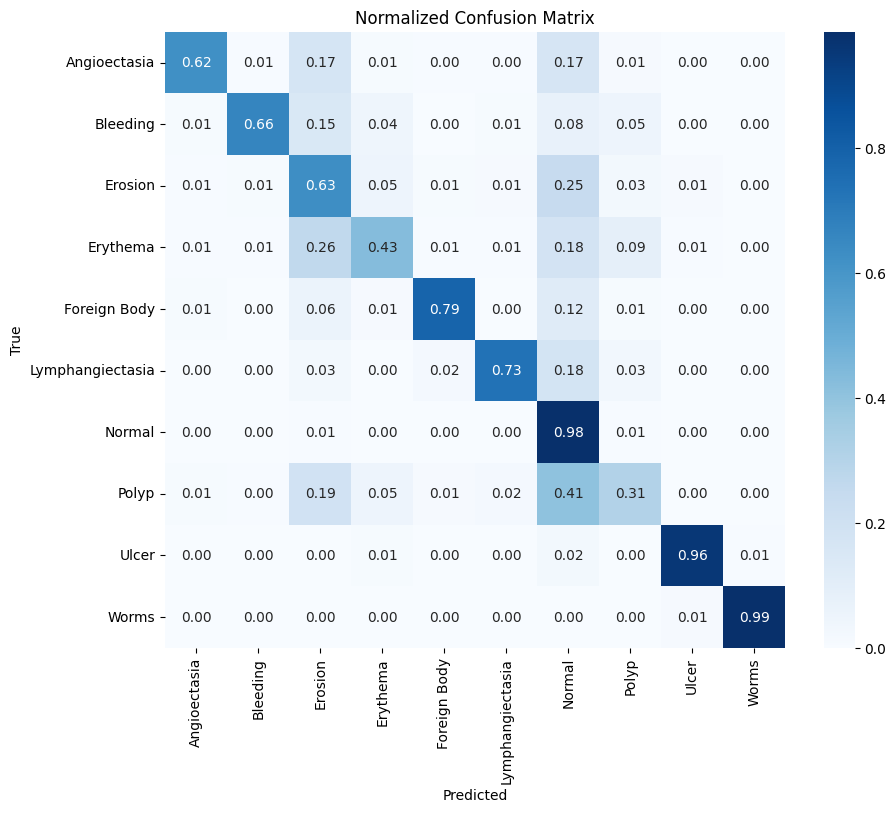

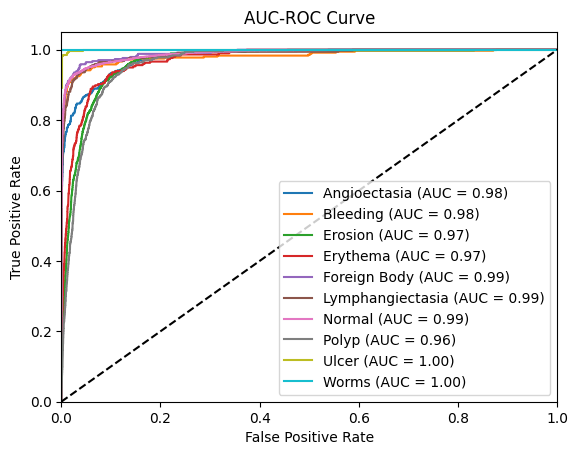

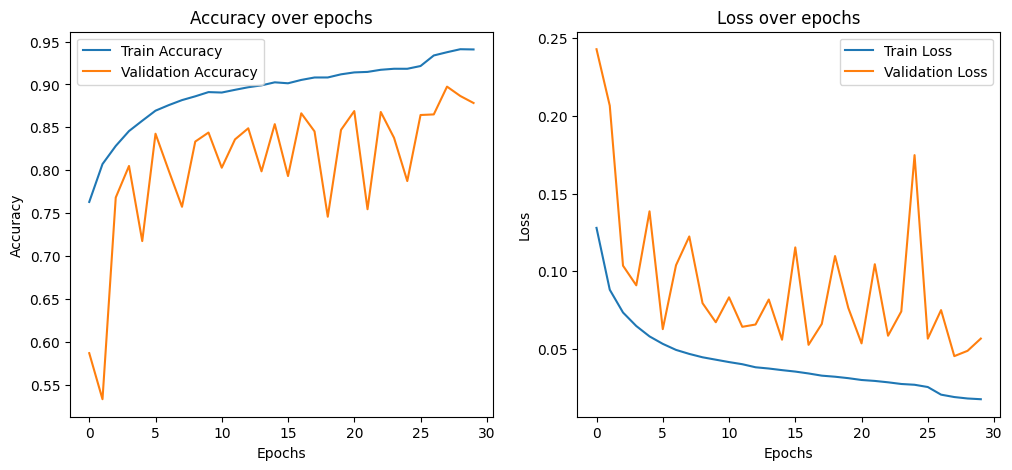

Confusion matrix saved to /kaggle/working/confusion_matrix.png
AUC-ROC curve saved to /kaggle/working/roc_curve.png
Training/validation accuracy and loss plots saved to /kaggle/working/train_val_plots.png
Evaluation metrics report saved to /kaggle/working/metrics_report.json


In [12]:
# Predict on the validation set using the generator
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

#  Get true labels from the validation generator
y_val = validation_generator.classes  # Assuming classes are set in the generator
y_val_one_hot = to_categorical(y_val, num_classes=10)
class_names = list(validation_generator.class_indices.keys())

# Convert the class indices back to class names for both actual and predicted values
actual_class_names = [class_names[i] for i in y_val]
predicted_class_names = [class_names[i] for i in y_pred_classes]

# Create a DataFrame with the predicted probabilities for each class (y_pred)
df_predictions = pd.DataFrame(y_pred, columns=class_names)
image_paths = validation_generator.filepaths

# Add the image paths, actual class, and predicted class to the DataFrame
df_predictions.insert(0, 'image_path', image_paths)  # Insert image names as the first column
df_predictions['predicted_class'] = predicted_class_names  # Add predicted class as a column
df_predictions['actual_class'] = actual_class_names  # Add actual class as a column

# Save to Excel
output_path = '/kaggle/working/validation_results.xlsx'
df_predictions.to_excel(output_path, index=False)

print(f"Validation results with probabilities saved to {output_path}")

# Plot AUC-ROC curve for each class and save it as PNG
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val)
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
roc_curve_path = '/kaggle/working/roc_curve.png'
plt.savefig(roc_curve_path, format='png')  # Save the AUC-ROC curve plot as PNG
plt.show()

# Print Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred_classes, normalize='true')
print(cm)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=class_names))

# Plot normalized Confusion Matrix and save it as PNG
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
conf_matrix_path = '/kaggle/working/confusion_matrix.png'
plt.savefig(conf_matrix_path, format='png')  # Save the confusion matrix plot as PNG
plt.show()

# Plot training & validation accuracy and loss over epochs and save them as PNG
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

train_val_plot_path = '/kaggle/working/train_val_plots.png'
plt.savefig(train_val_plot_path, format='png')  # Save the accuracy and loss plot as PNG
plt.show()

# Generate and save evaluation metrics as JSON
metrics_report = generate_metrics_report(y_val_one_hot, y_pred)
metrics_report_path = '/kaggle/working/metrics_report.json'
with open(metrics_report_path, 'w') as f:
    f.write(metrics_report)

# Output file paths
print(f"Confusion matrix saved to {conf_matrix_path}")
print(f"AUC-ROC curve saved to {roc_curve_path}")
print(f"Training/validation accuracy and loss plots saved to {train_val_plot_path}")
print(f"Evaluation metrics report saved to {metrics_report_path}")

# Testing

In [13]:
y_pred = model.predict(test_generator)
image_paths = test_generator.filepaths

# Save the DataFrame to Excel
output_path = '/kaggle/working/test_predictions.xlsx'
save_predictions_to_excel(image_paths, y_pred, output_path)
print(f"Predictions saved to {output_path}")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 36s 982ms/step
Predictions saved to /kaggle/working/test_predictions.xlsx


In [ ]:
# Modify the pathname to match the requirement of submission
# Read the Excel file into a DataFrame
df = pd.read_excel('/kaggle/working/test_predictions.xlsx')

# Apply the Path().name method to extract just the image name and its extension
df['image_path'] = df['image_path'].apply(lambda x: Path(x).name)

# Save the modified DataFrame back to an Excel file
df.to_excel('/kaggle/working/updated_test_predictions.xlsx', index=False)

print("File saved successfully with image names and extensions.")